# CIS 5450 Final Project: Analyzing TripAdvisor Hotel Reviews

# Motivation

One of the first and most important things people do when planning their travel itineraries and booking hotels is reading online reviews. [TripAdvisor](https://www.tripadvisor.com/) is a widely-used travel website that allows users to search up hotels in destinations around the world, and also allows people to write and browse hotel reviews. The reviews consist of a text, where the user describes their experiences and opinions, as well as a variety of different types of ratings for the hotel. 

We want to explore what factors affect the ratings of a particular hotel. In particular, the dataset we plan to use includes a detailed breakdown of different types of text reviews and ratings scraped from TripAdvisor, so we can delve deeper into factors that specifically affect certain ratings more than others. In addition, since we are given some information on the user who submitted the review for a particular hotel, our main focus will be determining if there are correlations between the nature of the review and the overall ratings of the hotel. In the end, we hope to be able to predict the overall rating a particular user gives to a hotel based on text analyses as well as other features given in the dataset, including additional features we engineer.  


# Data Cleaning & Pre-processing

In [ ]:
# Imports
import pandas as pd
from google.colab import drive
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import Counter
from wordcloud import WordCloud
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

Link to CSV File: [review.txt](http://www.cs.cmu.edu/~jiweil/review.txt.zip)

Link to Google Drive Folder: [CIS 5450 Final Project](https://drive.google.com/drive/folders/1q-ue2vmx3ku87GZGs-fiE95OII0Uaiiy?usp=sharing)

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read file from Google Drive and store it in a DataFrame
data = []
with open('/content/drive/MyDrive/CIS 5450 Final Project/review 2.txt', 'r') as file:
    for line in file:
        data.append(json.loads(line))

reviews_df = pd.DataFrame(data)

In [ ]:
# Looking at the raw dataframe
reviews_df.head(2)

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,"December 17, 2012",147639004,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,"December 18, 2012",147697954,False
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",August 2012,1762573,0,"December 17, 2012",147625723,False
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",December 2012,1762573,0,"December 17, 2012",147612823,False


In [ ]:
# Give "offering_id" a more understandable name
reviews_df = reviews_df.rename(columns={'offering_id': 'hotel_id'})

Note: **offering_id** is the hotel that the rating is assigned to the review (hypothesized from reading reviews with the same id, so we'll rename this column to **hotel_id**)

We notice from the columns that 2 of the columns, ratings and author, contain a list of data (sub-fields). We would like to use the sub-fields for more detailed analysis, so we'll split them up into individual dataframes to look at them more closely.

In [ ]:
# Creating ratings_df, author_df from "flattening" the 'ratings' column in reviews_df
ratings_df = pd.json_normalize(reviews_df['ratings'])
author_df = pd.json_normalize(reviews_df['author'])

# Concatenating all flattened info into large dataframe for future use
complete_df = reviews_df.drop(['ratings','title','text','author','hotel_id','num_helpful_votes','id','via_mobile'], axis=1)
complete_df = pd.concat([complete_df, author_df.drop(['location','username'], axis=1)], axis=1)
complete_df = pd.concat([complete_df, ratings_df.drop(['check_in_front_desk','business_service_(e_g_internet_access)'], axis=1)], axis=1)

# Here, we combine the data with some of the original columns in reviews_df so 
# that we can merge dataframes later on/more easily explore relationships between
# all variables.
ratings_df = pd.concat([reviews_df, ratings_df], axis=1)
# Dropping the redundant/text columns
ratings_df.drop(['author','ratings','title','text','date'], axis=1, inplace=True)
ratings_df.head()

,date_stayed,hotel_id,num_helpful_votes,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,check_in_front_desk,business_service_(e_g_internet_access)
0,December 2012,93338,0,147643103,False,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN
1,December 2012,93338,0,147639004,False,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN
2,December 2012,1762573,0,147697954,False,4.0,5.0,4.0,4.0,5.0,4.0,4.0,NaN,NaN
3,August 2012,1762573,0,147625723,False,5.0,5.0,4.0,5.0,5.0,5.0,5.0,NaN,NaN
4,December 2012,1762573,0,147612823,False,4.0,5.0,4.0,3.0,5.0,5.0,5.0,NaN,NaN


In [ ]:
# Getting an idea of how many columns and rows there are
print(ratings_df.shape)

# Upon inspection, the following two columns appear to have lots of Nans
print(ratings_df['check_in_front_desk'].isna().sum())
print(ratings_df['business_service_(e_g_internet_access)'].isna().sum())

(878561, 14)
778777
812832


## Removing unwanted columns

In [ ]:
# Dropping two of the columns
ratings_df = ratings_df.drop(['check_in_front_desk','business_service_(e_g_internet_access)'], axis=1)

It looks like most of the values in the last 2 columns are blank, so we'll disregard those columns for now.

In [ ]:
# Checking the types of each column—will be important in future analyses
# i.e. converting dates
ratings_df.dtypes

date_stayed           object
hotel_id               int64
num_helpful_votes      int64
id                     int64
via_mobile              bool
service              float64
cleanliness          float64
overall              float64
value                float64
location             float64
sleep_quality        float64
rooms                float64
dtype: object

Below we will repeat the same steps with the Author column.

In [ ]:
# Creating author_df dataframe from flattening the author column
author_df = pd.json_normalize(reviews_df['author'])
author_df = author_df.drop('id',axis=1)
author_df = pd.concat([reviews_df, author_df], axis=1)
author_df.drop(['ratings','title','text','author','date_stayed','num_helpful_votes','date','via_mobile'], axis=1, inplace=True)

author_df.head()

,hotel_id,id,username,num_cities,num_reviews,num_type_reviews,location
0,93338,147643103,Papa_Panda,22.0,29.0,24.0,Gold Coast
1,93338,147639004,Maureen V,2.0,2.0,NaN,"Sydney, New South Wales, Australia"
2,1762573,147697954,vuguru,12.0,14.0,14.0,Houston
3,1762573,147625723,Hotel-Designer,5.0,5.0,5.0,"Laguna Beach, CA"
4,1762573,147612823,JamesE339,34.0,104.0,49.0,"Saint Louis, Missouri"


In [ ]:
print(author_df.shape)
print(author_df.dtypes)

(878561, 7)
hotel_id              int64
id                    int64
username             object
num_cities          float64
num_reviews         float64
num_type_reviews    float64
location             object
dtype: object


In [ ]:
# Casting datatypes of certain columns to string
author_df = author_df.astype({'username':'string','location': 'string'})

In [ ]:
print(reviews_df.shape)
print(reviews_df['date_stayed'].isna().sum())
print(reviews_df['id'].isna().sum())

(878561, 10)
67588
0


In [ ]:
# Converting boolean to 0s and 1s (False is 0, True is 1)
reviews_df['via_mobile'] = reviews_df['via_mobile'].apply(lambda x : 0 if False else 1)

In [ ]:
# Clean some of the variables so it is more presentable and understandable
reviews_df['overall_rating'] = reviews_df['ratings'].apply(lambda x: x['overall'])
reviews_df['title'] = reviews_df['title'].apply(lambda x: x.replace('"', '')[1:-1])
reviews_df['text'] = reviews_df['text'].apply(lambda x: x.replace('"', ''))
reviews_df['comments'] = reviews_df['title'] + ' ' + reviews_df['text']
reviews_df['user'] = reviews_df['author'].apply(lambda x: x['username'])

In [ ]:
reviews_df.head(1)

,ratings,title,text,author,date_stayed,hotel_id,num_helpful_votes,date,id,via_mobile,overall_rating,comments,user
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",Truly is Jewel of the Upper Wets Side,Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,1,5.0,Truly is Jewel of the Upper Wets Side Stayed i...,Papa_Panda


## Tokenization (all words)

Next, we will look at the text data specifically. There are 2 columns of interest: `'title'`, which is the title a particular user's review, and `'text'`, which is the actual body of the review. We will perform a similar analysis to the one we did in HW2, and will also use **sentiment analysis** techniques for additional feature engineering. 

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# stop words
stop = stopwords.words('english')

In [ ]:
# Performs text tokenization by converting the input text to lowercase, removing 
# punctuation, splitting it into individual words, removing stop words, and 
# returning the resulting list of words as tokens.
def tokenize_text(text):
  text = text.lower()
  return [word.strip(string.punctuation) for word in text.split(" ") if word.strip(string.punctuation) not in stop
          and not word.strip(string.punctuation).isdigit()]

In [ ]:
# Tokenizing all the text data (title + text combined)
reviews_df['all_tokens'] = reviews_df['comments'].apply(tokenize_text)
reviews_df.head(1)

,ratings,title,text,author,date_stayed,hotel_id,num_helpful_votes,date,id,via_mobile,overall_rating,comments,user,all_tokens
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",Truly is Jewel of the Upper Wets Side,Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,1,5.0,Truly is Jewel of the Upper Wets Side Stayed i...,Papa_Panda,"[truly, jewel, upper, wets, side, stayed, king..."
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",My home away from home!,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,"December 17, 2012",147639004,1,5.0,"My home away from home! On every visit to NYC,...",Maureen V,"[home, away, home, every, visit, nyc, hotel, b..."
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",Great Stay,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,"December 18, 2012",147697954,1,4.0,Great Stay This is a great property in Midtown...,vuguru,"[great, stay, great, property, midtown, two, d..."


# Data Exploration

## Non-Text EDA

First, we use the describe() method to get a general sense of the spread and distribution of each numerical column.

We do this on each our 3 main dataframes that we processed earlier.

In [ ]:
reviews_df.describe()

,hotel_id,num_helpful_votes,id,via_mobile,overall_rating
count,8.785610e+05,878561.000000,8.785610e+05,878561.0,878561.000000
mean,3.058972e+05,1.153104,8.633481e+07,1.0,3.936228
std,4.388314e+05,2.898120,4.999254e+07,0.0,1.165074
min,7.257200e+04,0.000000,2.243990e+05,1.0,0.000000
25%,8.999800e+04,0.000000,3.488850e+07,1.0,3.000000
50%,1.114080e+05,0.000000,1.113905e+08,1.0,4.000000
75%,2.416400e+05,1.000000,1.283089e+08,1.0,5.000000
max,3.574675e+06,515.000000,1.478017e+08,1.0,5.000000


The numerical columns in the reviews_df dataframe do not contain too much helpful data to extract.

The `'num_helpful_votes'` column has a very low standard deviation of less than 3, and at least 75% of the reviews have at most 1 upvote/like. By itself, this column may not be extremely helpful for predicting the rating that the user gave to the hotel, but it may be more interesting to just look at the reviews with a significant number of helpful votes to see if there is a trend there.

Next, looking at the `'overall_rating'` distribution, we see that there may be a **class imbalance** here to take into consideration for our modeling. We see that more than 50% of the data consists of ratings of 4 or 5, and more than 75% of the data consists of ratings of 3, 4, or 5. This leaves very few ratings less than 5 (0, 1, or 2). As a result, this could cause poor prediction models for reviews that gave low ratings.

Since the `'via_mobile'` column does not provide much additional information (0 standard deviation), we will remove this column from our analysis.

In [ ]:
reviews_df = reviews_df.drop('via_mobile', axis=1)

In [ ]:
ratings_df.describe()

,hotel_id,num_helpful_votes,id,service,cleanliness,overall,value,location,sleep_quality,rooms
count,8.785610e+05,878561.000000,8.785610e+05,760918.000000,759835.000000,878561.000000,753695.000000,664904.000000,500903.000000,705404.000000
mean,3.058972e+05,1.153104,8.633481e+07,4.069742,4.208512,3.936228,3.896310,4.415007,4.114891,3.921873
std,4.388314e+05,2.898120,4.999254e+07,1.179085,1.075466,1.165074,1.179857,0.889482,1.112003,1.149181
min,7.257200e+04,0.000000,2.243990e+05,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,8.999800e+04,0.000000,3.488850e+07,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,3.000000
50%,1.114080e+05,0.000000,1.113905e+08,4.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000
75%,2.416400e+05,1.000000,1.283089e+08,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,3.574675e+06,515.000000,1.478017e+08,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Within the detailed breakdown of different types of ratings, we see that again, the ratings are generally quite high/favorable, consisting of of mostly the range from 3-5 (skewed left).

Though the distributions appear to be somewhat similar from the table above, we will explore which ratings have the highest correlation/effect on the reviewer's overall judgment.

In [ ]:
author_df.describe()

,hotel_id,id,num_cities,num_reviews,num_type_reviews
count,8.785610e+05,8.785610e+05,613968.000000,801438.000000,515610.000000
mean,3.058972e+05,8.633481e+07,12.853202,17.629102,14.302696
std,4.388314e+05,4.999254e+07,14.702529,28.973244,17.163277
min,7.257200e+04,2.243990e+05,2.000000,1.000000,3.000000
25%,8.999800e+04,3.488850e+07,4.000000,2.000000,5.000000
50%,1.114080e+05,1.113905e+08,8.000000,8.000000,9.000000
75%,2.416400e+05,1.283089e+08,16.000000,22.000000,17.000000
max,3.574675e+06,1.478017e+08,284.000000,935.000000,330.000000


In [ ]:
# Checking for Nans
print(author_df['username'].nunique())
print(author_df['username'].isna().sum())

536952
0


Of the numerical columns in `author_df`, we will most likely use `'num_cities'` and `'num_reviews'` as features to train our models, since they have non-negligible standard deviation and also appear to have interesting spreads/distributions. From reviewing the TripAdvisors website, `'num_cities'` most likely refers to how many different places the user has visited (although this is likely self-reported). `'num_reviews'` is simply the total number of reviews the user has written. 

However, it is unclear what `'num_type_reviews'` refers to, so though we will keep this column in our analyses for now, we will most likely not use it as a feature in our models. 

In [ ]:
ratings_by_hotel = ratings_df.groupby(by='hotel_id', as_index=False).agg({'num_helpful_votes': 'mean','service':'mean','cleanliness':'mean','overall':'mean','value':'mean','location':'mean','sleep_quality':'mean','rooms':'mean'})
ratings_by_hotel.head()

,hotel_id,num_helpful_votes,service,cleanliness,overall,value,location,sleep_quality,rooms
0,72572,1.833333,4.500000,4.605128,4.328704,4.257653,4.488701,4.342222,4.238356
1,72579,0.813636,4.034826,4.089109,3.640909,3.915423,4.073446,3.804054,3.679558
2,72586,1.239852,4.016598,4.050209,3.767528,3.892116,4.368932,4.090909,3.767123
3,72598,0.901639,3.303571,3.236364,2.983607,3.142857,3.113208,3.325581,3.096154
4,73236,0.695652,4.217391,2.913043,3.173913,3.739130,4.190476,3.500000,3.190476


In [ ]:
ratings_corr = ratings_by_hotel.corr()

Interesting things to note from correlation matrix:


*   If we compare all correlation coefficients with the "`overall`" rating, we see that most of them are **highly correlated**, as expected, but some more so than others. For example, the **rooms** rating had the highest correlation with the overall rating, while the **location** had the smallest correlation (by a significant margin)
*   Looking at the "`num_helpful_votes`", we see that it is actually **negatively** correlated with all the ratings (the higher the average number of helpful votes a hotel's comments had, the lower its ratings). This suggests that perhaps the ratings with a high number of helpful votes are more negative/extreme in general. We will test this hypothesis later. 



<Axes: >

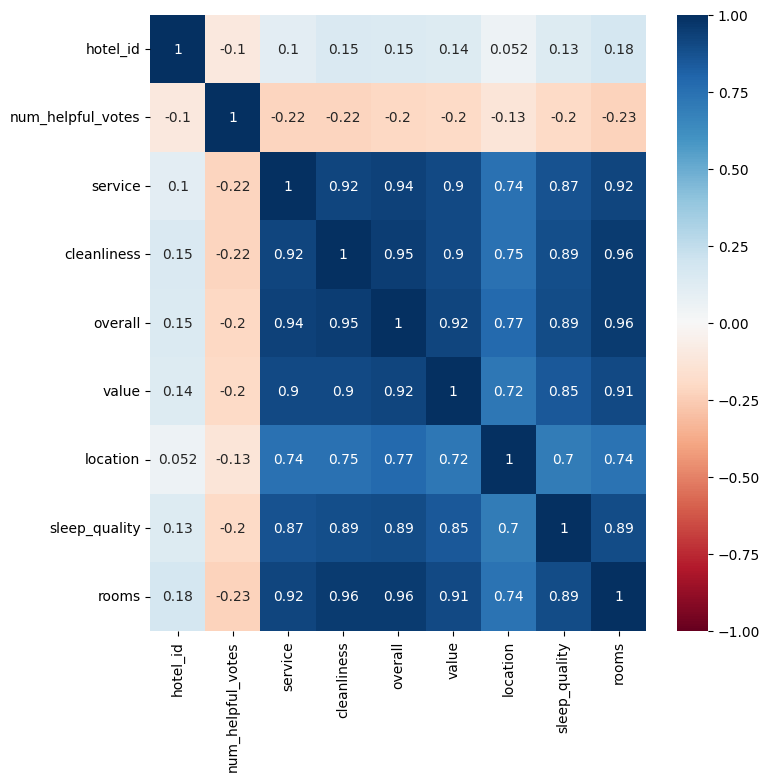

In [ ]:
# Heatmap of Correlations
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(ratings_corr, cmap = 'RdBu', vmin = -1, vmax = 1, center = 0, annot=True)

In [ ]:
review_dates_df = ratings_df.dropna(subset=['date_stayed'])
# define function to convert date string to datetime object
def convert_date(date_string):
    try:
        return pd.to_datetime(date_string)
    except ValueError:
        return pd.NaT 
review_dates_df['date_stayed'] = review_dates_df['date_stayed'].apply(convert_date)
# drop rows with NaT values
review_dates_df = review_dates_df.dropna(subset=['date_stayed'])

<ipython-input-29-559280e540d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_dates_df['date_stayed'] = review_dates_df['date_stayed'].apply(convert_date)


In [ ]:
# Convert to datetime objects
review_dates_df['date_stayed'] = pd.to_datetime(review_dates_df['date_stayed'].apply(lambda x: str(x)))
review_dates_df.head()

,date_stayed,hotel_id,num_helpful_votes,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms
0,2012-12-01,93338,0,147643103,False,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,2012-12-01,93338,0,147639004,False,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,2012-12-01,1762573,0,147697954,False,4.0,5.0,4.0,4.0,5.0,4.0,4.0
3,2012-08-01,1762573,0,147625723,False,5.0,5.0,4.0,5.0,5.0,5.0,5.0
4,2012-12-01,1762573,0,147612823,False,4.0,5.0,4.0,3.0,5.0,5.0,5.0


In [ ]:
# Get the month of each row
review_dates_df['month'] = review_dates_df['date_stayed'].dt.month

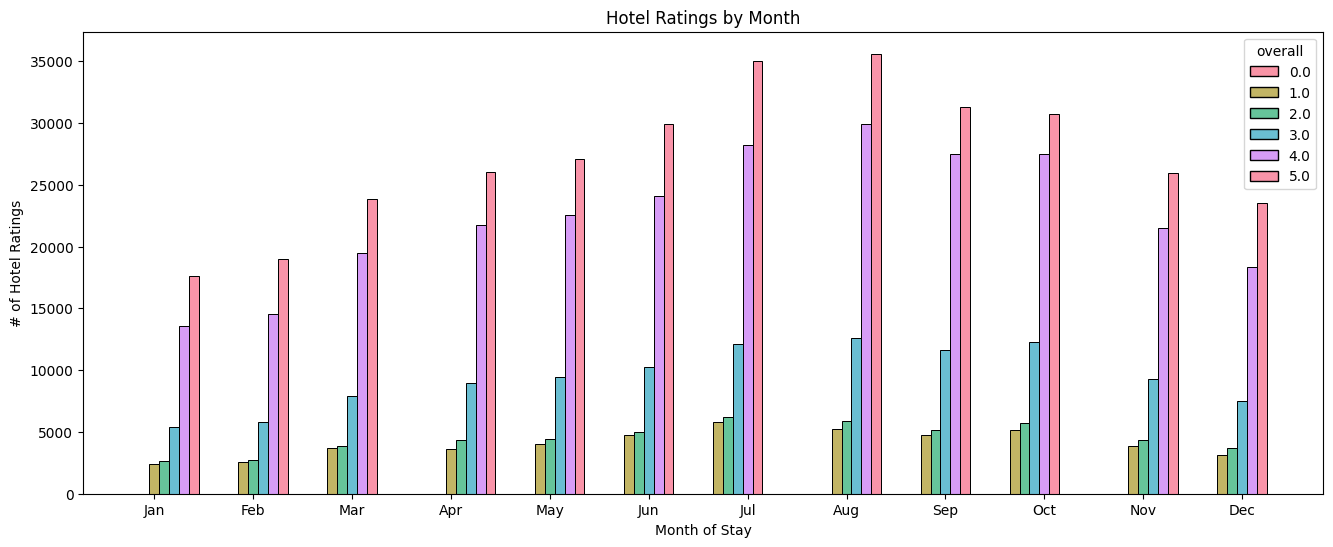

In [ ]:
# Create bar graph by month showing the ratings given in each month across all hotels
fig, ax = plt.subplots(figsize=(16, 6))
ordered_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sorted_months = review_dates_df.sort_values(by='month')
sns.histplot(x=sorted_months['month'], hue=sorted_months['overall'], multiple='dodge', palette = 'husl', shrink = 2, binwidth=0.3)
ax.set_xticks(sorted_months['month'].unique())
ax.set_xticklabels(ordered_list)

ax.set_title('Hotel Ratings by Month')
ax.set_xlabel('Month of Stay')
ax.set_ylabel('# of Hotel Ratings')

plt.show()

It looks like there are **more** hotel ratings in the **summer** months, with the number of reviews steadily **increasing** from Jan to **Jul/Aug** and then steadily **decreasing** from **Aug-Dec**. This is most likely due to more people in general going on vacation in the summer months, so more people can write hotel reviews. 

Otherwise, each individual rating (from 1-5) follows a similar pattern, where the number of ratings for each unique rating roughly **doubles** from Jan to Aug. 

Note that the number of 0-ratings are negligible.

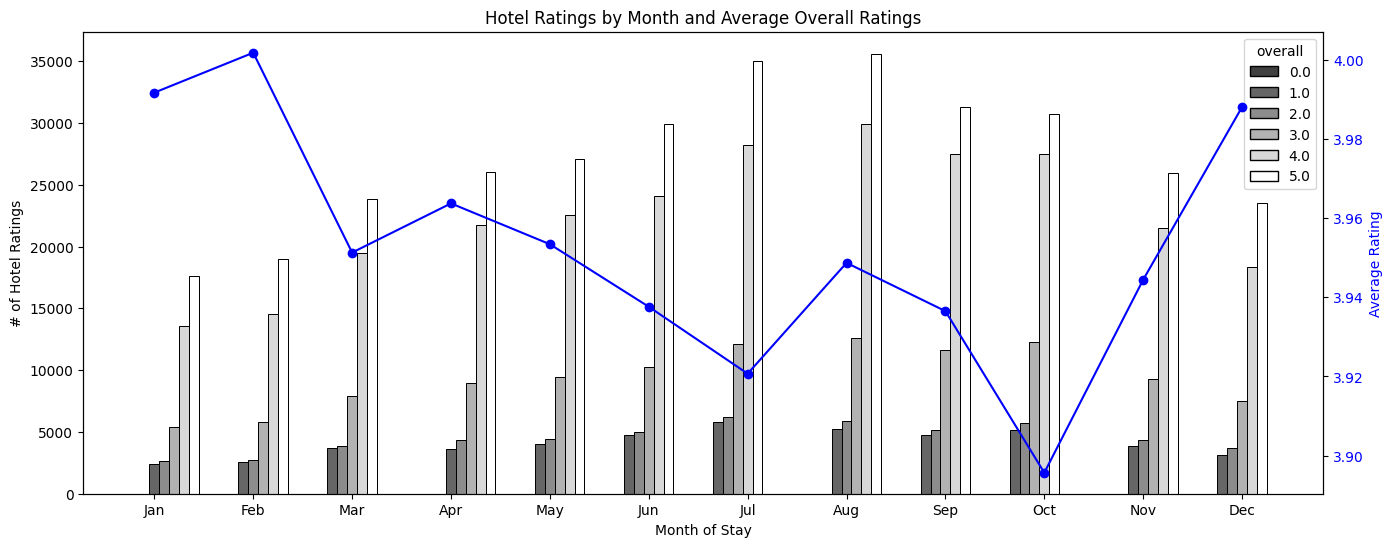

In [ ]:
# Line plots to discover trends between the date of stay and the overall score

# Calculate the mean rating for each month
mean_ratings = review_dates_df.groupby('month')['overall'].mean()

# Create bar graph by month showing the ratings given in each month across all hotels
fig, ax = plt.subplots(figsize=(16, 6))
ordered_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sorted_months = review_dates_df.sort_values(by='month')
sns.histplot(x=sorted_months['month'], hue=sorted_months['overall'], multiple='dodge', palette = 'gray', shrink = 2, binwidth=0.3)
ax.set_xticks(sorted_months['month'].unique())
ax.set_xticklabels(ordered_list)

# Plot the mean rating as a line plot on top of the histogram
ax2 = ax.twinx()
ax2.plot(mean_ratings.index, mean_ratings.values, color='blue', marker='o')
ax2.set_ylabel('Average Rating', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax.set_title('Hotel Ratings by Month and Average Overall Ratings')
ax.set_xlabel('Month of Stay')
ax.set_ylabel('# of Hotel Ratings')

plt.show()


In the above graph, we juxtapose the average overall rating of all hotels in each month with the histplot from above. The results are quite interesting — in general, it seems that as the total number of hotel reviews **increased**, the average rating **decreased**. 

Additionally, the winter months had the highest average overall ratings, while the summer months generally had lower ratings (with October having the lowest rating). 

In [ ]:
# Get the year of each row and sort it to look at their frequencies
review_dates_df['year'] = pd.to_datetime(review_dates_df['date_stayed'], format='%B %Y %d').dt.year
year_counts = review_dates_df['year'].value_counts().sort_index()

print(year_counts)

1999        30
2000        38
2001        52
2002       153
2003       945
2004      4376
2005     22299
2006     29392
2007     46312
2008     54329
2009     76101
2010    113157
2011    199289
2012    264468
Name: year, dtype: int64


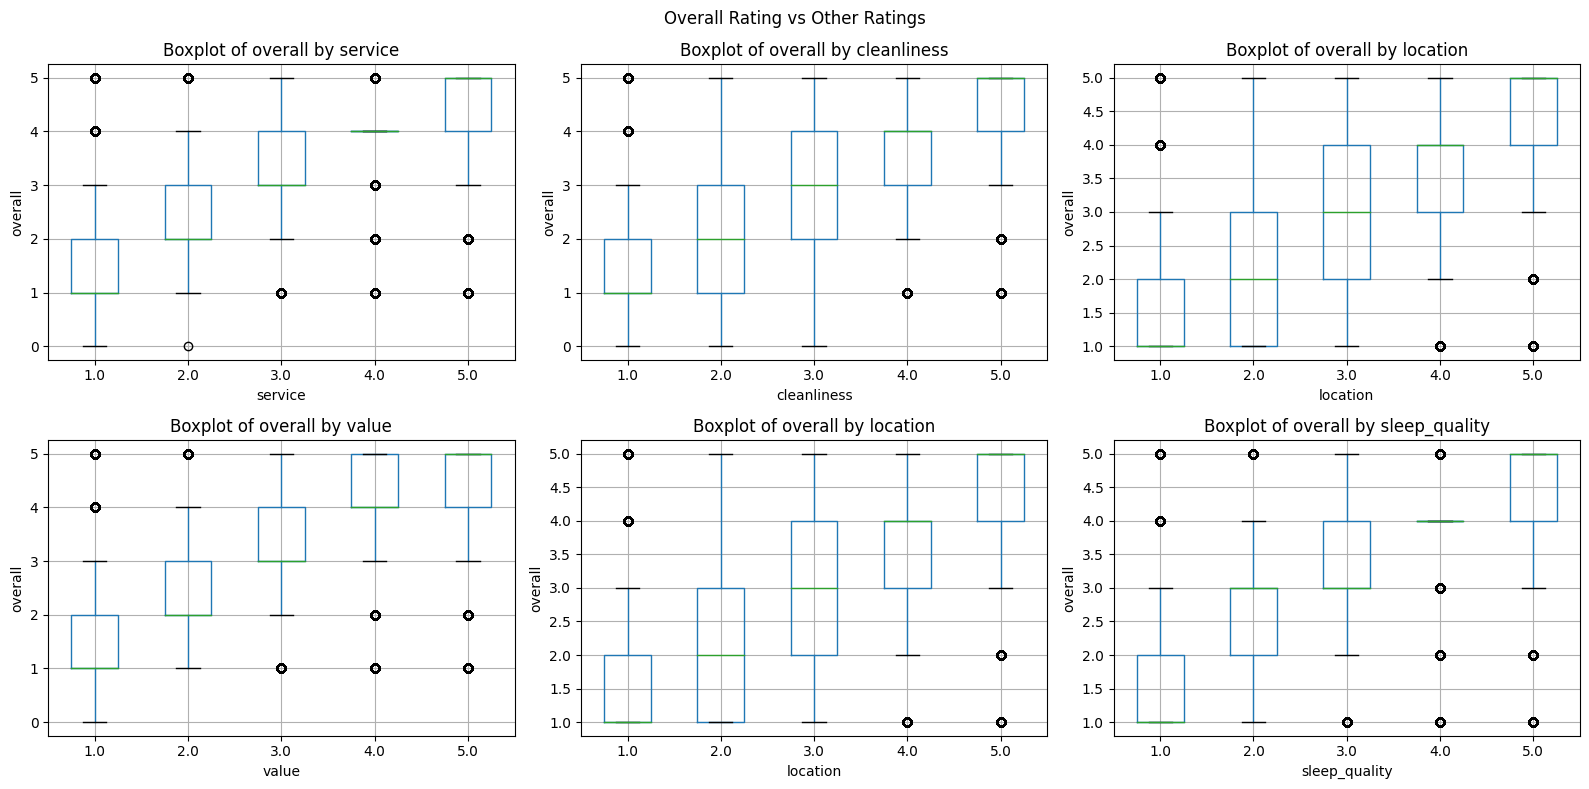

In [ ]:
# Define the variables to use for the boxplots
x_var = 'overall'
y_vars = ['service', 'cleanliness', 'location', 'value', 'location', 'sleep_quality']

# Create a 2x3 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = ax.flatten()  # Flattens the axes array into a 1D array

# Create a boxplot for each variable and add it to the corresponding subplot
for i, y_var in enumerate(y_vars):
    row = i // 3  # Determines the row number for the current subplot
    col = i % 3   # Determines the column number for the current subplot
    ratings_df.boxplot(column=x_var, by=y_var, ax=axes[i])
    axes[i].set_xlabel(y_var)
    axes[i].set_ylabel(x_var)
    axes[i].set_title('Boxplot of {} by {}'.format(x_var, y_var))
fig.suptitle('Overall Rating vs Other Ratings')
plt.tight_layout()
plt.show()

From comparing all sub-ratings to the overall rating, we confirm our previous analyses of the ratings correlation matrix. Specifically, we see that each sub-rating is **highly** correlated with the overall rating, especially if we compare the **medians** (green lines) of each score. For example, in almost every case, we have that a sub-rating of 4 correlated to an overall rating of 4. The only time this did not happen was in the `'sleep quality'` subplot, where a sleep quality of 2 or 3 corresponded with a median overall rating of 3. 

However, in every subplot, we see that the range of the boxplots increased directly with respect to the overall rating. 

One thing that is interesting to note is that in two of the subplots (sleep quality and service), a sub-rating of 4 almost always corresponded to exactly an overall rating of 4, as seen by the lack of a box (lower quartile = median = upper quartile).

In general, these plots tell us that when people submit ratings, they tend to submit very **similar** ratings across the board.

As such, we can safely focus on just the overall ratings of each hotel in our later analyses.

## Text EDA

For our next analysis, we will explore the relationships related to text lengths of the reviews.

In [ ]:
reviews_df['title_length'] = reviews_df['title'].apply(len)
reviews_df['text_length'] = reviews_df['text'].apply(len)

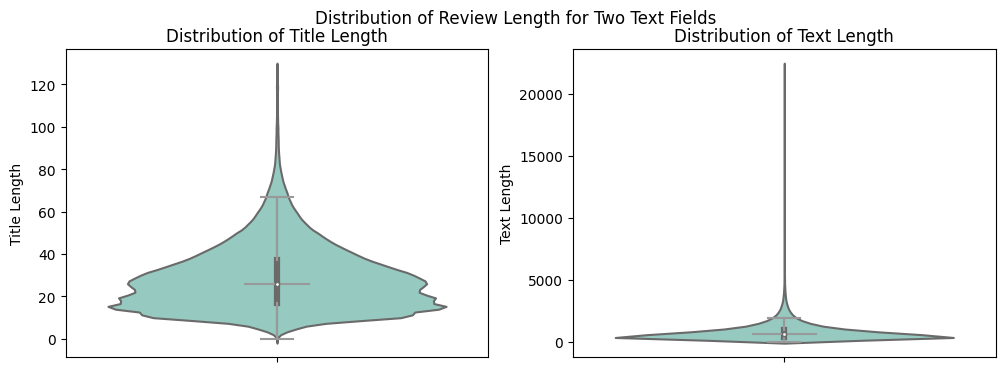

In [ ]:
# Violin and Boxplots to analyze distribution of title and text lengths
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot violin plot of review length for title length on left subplot
sns.violinplot(y=reviews_df['title_length'], ax=axs[0], inner="box", palette="Set3", showfliers=False)
sns.boxplot(y=reviews_df['title_length'], ax=axs[0], color="white", width=0.15, showfliers=False)
axs[0].set_title('Distribution of Title Length')
axs[0].set_ylabel('Title Length')

# Plot violin plot of review length for text length on right subplot
sns.violinplot(y=reviews_df['text_length'], ax=axs[1], inner="box", palette="Set3", showfliers=False)
sns.boxplot(y=reviews_df['text_length'], ax=axs[1], color="white", width=0.15, showfliers=False)
axs[1].set_title('Distribution of Text Length')
axs[1].set_ylabel('Text Length')

fig.suptitle('Distribution of Review Length for Two Text Fields')

plt.show()

In [ ]:
# Calculate the quartiles and IQR
q1_title = reviews_df['title_length'].quantile(0.25)
q3_title = reviews_df['title_length'].quantile(0.75)
iqr_title = q3_title - q1_title

q1_text = reviews_df['text_length'].quantile(0.25)
q3_text = reviews_df['text_length'].quantile(0.75)
iqr_text = q3_text - q1_text

# Define the lower and upper bounds
lower_bound_title = q1_title - 1.5*iqr_title
upper_bound_title = q3_title + 1.5*iqr_title

lower_bound_text = q1_title - 1.5*iqr_text
upper_bound_text = q3_title + 1.5*iqr_text

# Remove outliers based on upper/lower bounds defined above
reviews_outliers = reviews_df[(reviews_df['title_length'] >= lower_bound_title) & (reviews_df['title_length'] <= upper_bound_title)]
reviews_outliers = reviews_outliers[(reviews_df['title_length'] >= lower_bound_text) & (reviews_df['text_length'] <= upper_bound_text)]

<ipython-input-38-6a2887a1c4f7>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews_outliers = reviews_outliers[(reviews_df['title_length'] >= lower_bound_text) & (reviews_df['text_length'] <= upper_bound_text)]


From these violin plots and the corresponding boxplots, we see that title lengths resembles a somewhat skewed normal distribution (higher frequencies of text lengths near smaller title lengths). We can also see this with the boxplot that shows a longer whisker from the median to the the 75th percentile than from thw median to the 25th percentile. Additionally, we see the presence of many outliers on the longer end of the spectrum, since there is a long, narrow spike on the top of the violin plot. 

This analysis also generally applies to the plot on the right depicting text length distribution, except to a more extreme degree since the text lengths have much a greater standard deviation. It is clear that a large number of people wrote around the median number of words from the horizontal spikes, and we also see outliers causing the top of the plot to become a long, narrow spike. 

Because we noticed so many outliers skewing our violin plots, we decided to look into removing the outliers. We used a standard formula for determining the cutoffs of the outliers, namely the 25th percentile - 1.5 times the interquartile range as the lower bound and the 75th percentile + 1.5 times the interquartile range as the upper bound. 

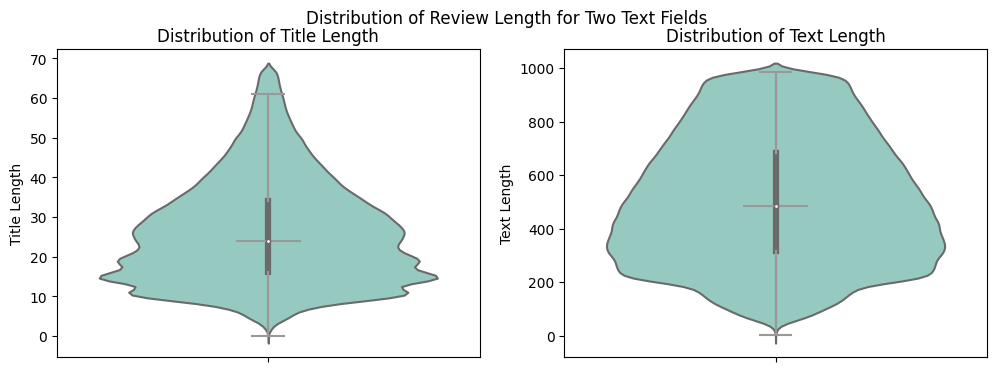

In [ ]:
# Redo plots without outliers
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot violin plot of review length for title length on left subplot
sns.violinplot(y=reviews_outliers['title_length'], ax=axs[0], inner="box", palette="Set3", showfliers=False)
sns.boxplot(y=reviews_outliers['title_length'], ax=axs[0], color="white", width=0.15, showfliers=False)
axs[0].set_title('Distribution of Title Length')
axs[0].set_ylabel('Title Length')

# Plot violin plot of review length for text length on right subplot
sns.violinplot(y=reviews_outliers['text_length'], ax=axs[1], inner="box", palette="Set3", showfliers=False)
sns.boxplot(y=reviews_outliers['text_length'], ax=axs[1], color="white", width=0.15, showfliers=False)
axs[1].set_title('Distribution of Text Length')
axs[1].set_ylabel('Text Length')

fig.suptitle('Distribution of Review Length for Two Text Fields')

plt.show()

Now, the violin plots no longer have the outliers and we can more easily see the shape of the distributions. It looks like both plots have a large number of reviewers writing around the median/slightly under the median number of words, while the upper end of the spectrum is skewed and has less density in terms of frequency. 

What is interesting to note is that the distribution of text length is now more normal-looking than that of the title length, with some skewing (but not as much). The boxplot for the plot on the right looks almost completely symmetric, and the violin plot shows us more detailed information on the actual density/breakdown of the review text lengths.

Based on our preliminary analysis of the text length, we would like to include it as an additional feature for our model to predict what overall rating a user will assign the hotel. 

### Word Cloud (Titles)

To better visualize the text data, we will utilize the ntlk package to extract digestable and usable information from the text.

In [ ]:
# generate top tokens for title column
review_titles = reviews_df['title'].tolist()
top_tokens_titles_list = [tokenize_text(token) for token in review_titles]
top_tokens_titles = [elem for sublist in top_tokens_titles_list for elem in sublist]

In [ ]:
# find the 20 most frequent words
top_20_words_title = [Counter(top_tokens_titles).most_common(20)[i] for i in range(20)]
top_20_words_title

[('great', 194250),
 ('hotel', 192584),
 ('location', 132251),
 ('stay', 84019),
 ('good', 67678),
 ('nice', 53774),
 ('service', 46059),
 ('excellent', 36488),
 ('place', 36190),
 ('staff', 35896),
 ('value', 29214),
 ('best', 22234),
 ('room', 21389),
 ('clean', 20031),
 ('perfect', 19780),
 ('rooms', 18955),
 ('wonderful', 18385),
 ('experience', 18086),
 ('price', 17416),
 ('new', 15480)]

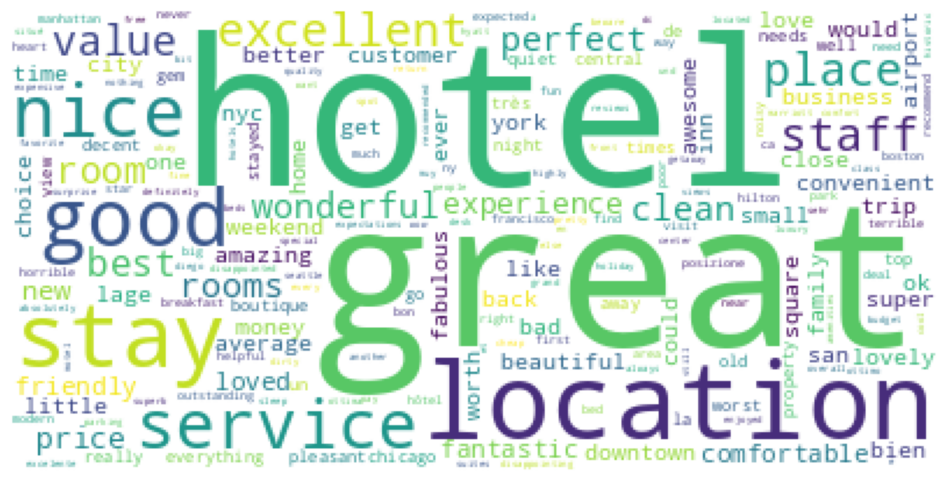

In [ ]:
# WordCloud for Titles
text = ""
for i in range(len(top_tokens_titles)):
  text += top_tokens_titles[i] + " "

wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(Counter(top_tokens_titles))
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Overall, the most common words are quite positive, which makes sense since the vast majority of ratings are 4-5. However, there are some words that are negative, and we will next extract the most common words in the text of bad ratings and perform sentiment analysis.

### Word Cloud (Titles + Text)

In [ ]:
# Create a dictionary of the words and their frequencies
words = {}
for sublist in reviews_df['all_tokens']:
    for token in sublist:
        if token in words.keys():
            words[token] += 1
        else:
            words[token] = 1

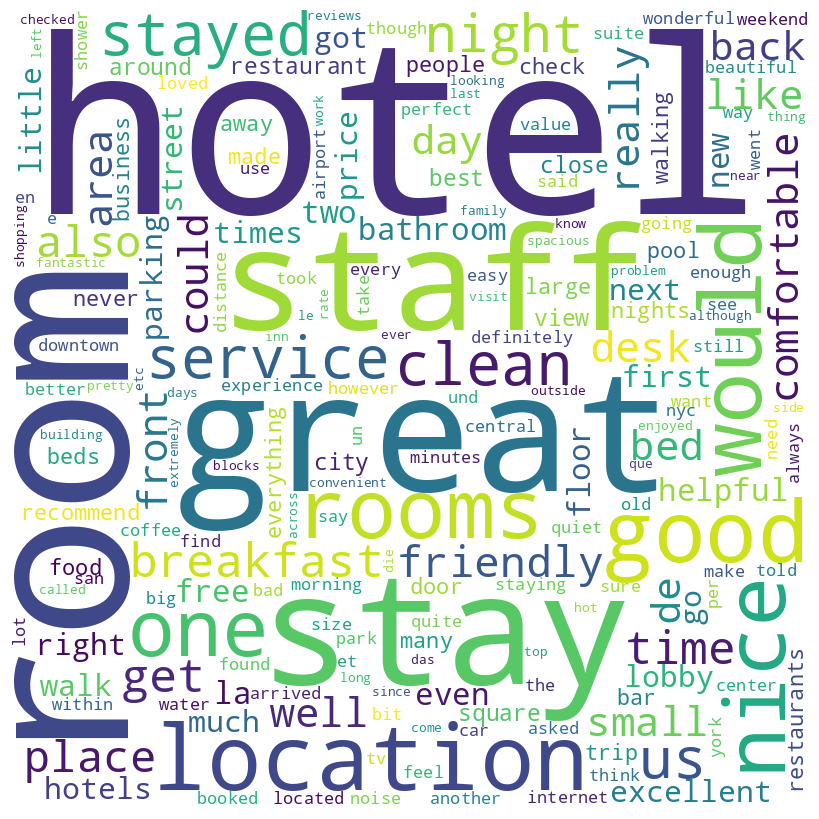

In [ ]:
# Create a word cloud for everything
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(words)

plt.figure(figsize=(12, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

This word cloud run on both titles and texts looks very similar to the one above which was just run on the titles, so this tells that perhaps users tend to repeat the most important words in their titles and texts. 

# Feature Engineering

## Extra Columns

In [ ]:
# Combines text and title columns into one big string
reviews_df['comments_length'] = reviews_df['comments'].apply(lambda x: len(x))

In [ ]:
reviews_df['date_stayed'] = reviews_df['date_stayed'].apply(convert_date)
# drop rows with NaT values
reviews_df = reviews_df.dropna(subset=['date_stayed'])

# Get the months
reviews_df['month'] = reviews_df['date_stayed'].dt.month

In [ ]:
# Keep only the columns that we need
reviews_df = reviews_df[['month', 'overall_rating', 'comments', 'comments_length']]
reviews_df.head(3)

## Separate into mini-batches



In [ ]:
output_folder = '/content/drive/MyDrive/CIS 5450 Final Project'

batch_size = 50000

# Separate and store data into mini files so RAM doesn't overflow 
num_batches = len(reviews_df) // batch_size + 1
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_df = reviews_df.iloc[start_idx:end_idx]
    
    # Define the file name for this batch
    file_name = f'{output_folder}/batch_{i}.csv'
    
    # Write the batch DataFrame to a CSV file
    batch_df.to_csv(file_name, index=False)

In [ ]:
reviews_df.shape

## Sentiment Analysis & Doc2Vec

Because text data is hard to use directly in modeling and classification, we will perform sentiment analysis. Each comment (title + text) has a score for negative, neutral, positive, and overall sentiment

Next, we will represent the text data as a set of numbers that a computer can understand. We use a tool called Doc2Vec to generate vector representations for each comment in the dataset, and the vectors capture the meaning of the comments in a way that can be used for analysis later on.

Once the sentiment analysis and vectorization tasks are complete, the we save the updated dataset for each batch to a new file. This process is repeated for each batch in the dataset in order to process the big dataset in manageable sections.

In [ ]:
nltk.download('vader_lexicon')

In [ ]:
# Initialize a sentiment object
sia = SentimentIntensityAnalyzer()

In [ ]:
for batch_number in range(num_batches):
  # get the csv
  cur_batch_df = pd.read_csv(f"/content/drive/MyDrive/CIS 5450 Final Project/batch_{batch_number}.csv")

  # perform sentiment analysis
  cur_batch_df['sentiment'] = cur_batch_df['comments'].apply(sia.polarity_scores)
  cur_batch_df['negative_score'] = cur_batch_df['sentiment'].apply(lambda x: x['neg'])
  cur_batch_df['neutral_score'] = cur_batch_df['sentiment'].apply(lambda x: x['neu'])
  cur_batch_df['positive_score'] = cur_batch_df['sentiment'].apply(lambda x: x['pos'])
  cur_batch_df['total_score'] = cur_batch_df['sentiment'].apply(lambda x: x['compound'])
  cur_batch_df.drop('sentiment', axis=1, inplace=True)

  # doc2vec vectorization
  documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(cur_batch_df["comments"].apply(lambda x: x.split(" ")))]
  model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

  doc2vec_df = cur_batch_df["comments"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
  doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
  cur_batch_df = pd.concat([cur_batch_df, doc2vec_df], axis=1)

  # show it
  cur_batch_df.head(3)

  # write it back to the csv
  file_name = f'{output_folder}/batch_{batch_number}.csv'
  cur_batch_df.to_csv(file_name, index=False)

In [ ]:
import glob

csv_folder = "/content/drive/MyDrive/CIS 5450 Final Project"

# get list of csv files in folder
csv_files = glob.glob(f"{csv_folder}/*.csv")

# read each CSV file into a list of dataframes
dfs = [pd.read_csv(csv_file) for csv_file in csv_files]

# concatenate the dataframes
reviews_df = pd.concat(dfs, ignore_index=True)

# Modeling/Classification

Main Objective: Predict the 'overall' rating a particular user gives to a hotel based on chosen features based almost purely on features engineered from the text data (`'title'`, `'text'` columns). 

For ease of reference here are the 10 features we choose to model on:

*   month (extracted from `'date_of_stay'`)
*   comments_length (length of the concatenation of `title` + `text` columns)
*   Sentiment analysis of comments (3 features)
**   **negative**, **positive**, and **neutral** scores
*   Doc2Vec Vectors of comments (5 vectors)



In [ ]:
# Drop all the rows in which the rating is 0 since there are only 8 ratings for 0
reviews_df = reviews_df[reviews_df['overall_rating'] != 0]

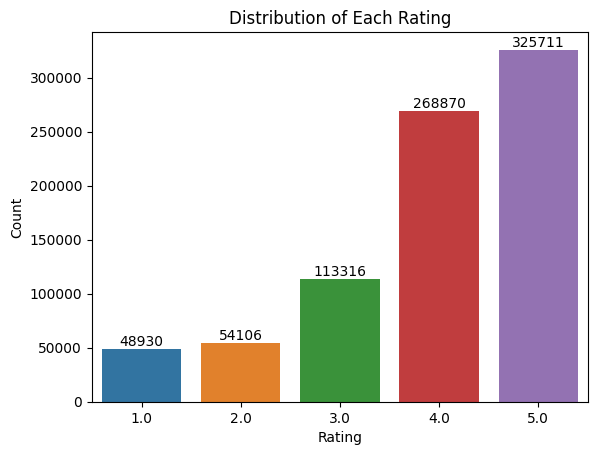

In [ ]:
# Plot the class distributions
ax = sns.countplot(data=reviews_df, x='overall_rating')

plt.title("Distribution of Each Rating")
plt.xlabel("Rating")
plt.ylabel("Count")

for i in ax.containers:
    ax.bar_label(i)

Based on the depicted plot, it is evident that the current dataset exhibits a substantial degree of imbalance, where the instances with a rating of 5 constitute over 40% of the entire dataset, while instances with a rating of 0 are almost non-existent. To address this issue, 2 effective approaches are to utilize oversampling and undersampling, which involves randomly duplicate examples in the minority class and
randomly delete examples in the majority class respectively.

## Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Drop columns that aren't inputs for our models
features = reviews_df.drop(['overall_rating', 'comments'], axis=1)

# The target column we are trying to predict
target = reviews_df[['overall_rating']]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
# Initialize a RandomOverSampler object and over sample our original dataset
ros = RandomOverSampler(random_state=42)
over_X_train, over_y_train = ros.fit_resample(X_train, y_train)

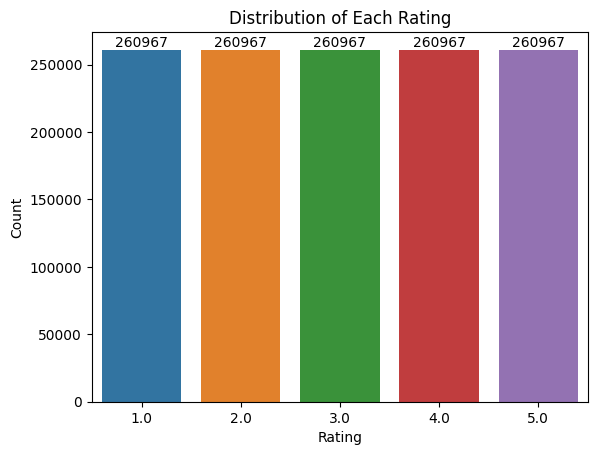

In [ ]:
# New class distribution after over-sampling
ax = sns.countplot(data=over_y_train, x='overall_rating')

plt.title("Distribution of Each Rating")
plt.xlabel("Rating")
plt.ylabel("Count")

for i in ax.containers:
    ax.bar_label(i)

We see that each category now has ~260k samples.

## Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Initialize a RandomUnderSampler object and over sample our original dataset
rus = RandomUnderSampler()
under_X_train, under_y_train = rus.fit_resample(X_train, y_train)

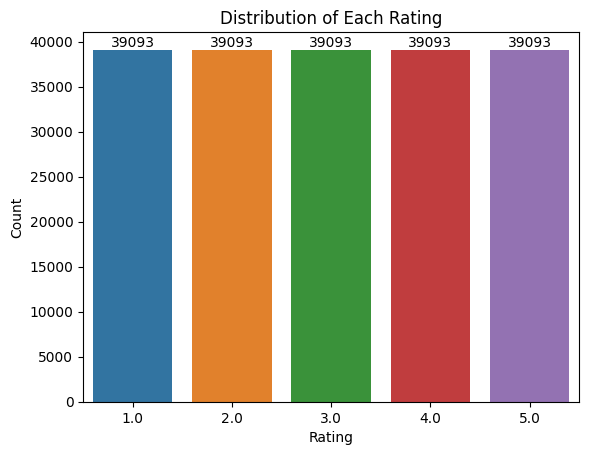

In [ ]:
# New class distribution after under-sampling
ax = sns.countplot(data=under_y_train, x='overall_rating')

plt.title("Distribution of Each Rating")
plt.xlabel("Rating")
plt.ylabel("Count")

for i in ax.containers:
    ax.bar_label(i)

In contrast with oversampling, undersampling decreases the number of samples in each category to roughly match the count of the smallest category (rating of 1 in our case). 

Because our dataset is already quite large (initially over 870k rows), we will use undersampling in the rest of our models since we still have ~40k samples per category. 

Additionally, oversampling would cause our dataset to become ~1.5 million rows, which is much more resource-intensive to analyze and is also more prone to overfitting. 

## Classification Metrics

Because we want to properly analyze how well each of our models perform, we will calculate the following information for each model:

1.   Accuracy
2.   Confusion Matrix (comparing actual results with predicted results for each rating)
3. Additional metrics (Precision, Recall, F1, Support)

Although **accuracy** is a good initial comparison point across different models, they do not tell the entire story. In our case, this is especially true given that we have a clas imbalance problem: If the model simply returned scores of 4 or 5 all the time, its accuracy would be quite high since there are many more higher-rated samples, while the accuracy rate for 1s and 2s could be much lower. 

This is why we will also analyze each model's **confusion matrix**, so we can see how well it predicts each individual category. 

Additional Metrics:

*   **Precision**: measures the proportion of true positive predictions among all positive predictions made by the model. A high precision indicates that the model is making very few false positive predictions, meaning that it is identifying the true positive cases with high confidence.
*   **Recall**: measures the proportion of true positive predictions among all actual positive cases in the dataset. A high recall indicates that the model is correctly identifying a high proportion of the true positive cases in the dataset.
*   **F1-score**: harmonic mean of precision/recall; a balanced measure that takes both precision and recall into account.
*   **Support**: number of actual occurrences of the class in the dataset. For example, if the support for a particular class is low, it could mean that the model is not generalizing well to new data.

Source: 
[scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Metrix class for our models later 
def calc_acc(model, y_pred, y_actual):
    # classification report
    print(classification_report(y_actual, y_pred))

    # draw confusion matrix
    cm = confusion_matrix(y_actual, y_pred)

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    tick_labels = np.unique(np.concatenate((y_actual, y_pred)))
    plt.xticks(np.arange(len(tick_labels))+0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels))+0.5, tick_labels)

    # accuracy
    acc = accuracy_score(y_actual, y_pred)
    print(f"Accuracy score: {acc}")

## PCA (Unsupervised)

Because our dataset has numerous columns and engineered features as well, we would like to use PCA to determine how many/which of our 10 chosen text-based features explain the most variance in the data.

In [ ]:
# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(under_X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Initialize a PCA object
pca = PCA()
pca.fit(X_train_scaled)

PCA()

In [ ]:
# Get the explained_variance_ratios
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)

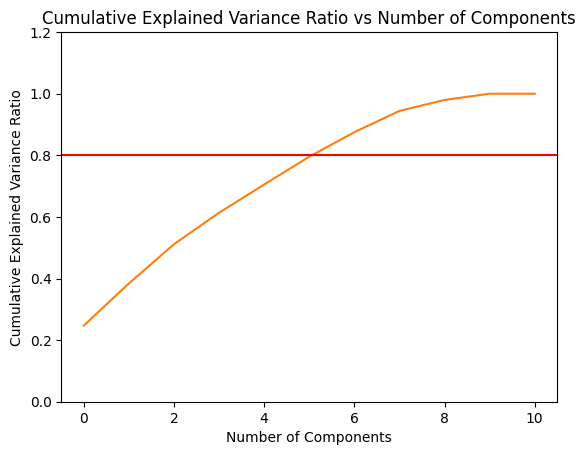

In [ ]:
# Plot the cumulative explained variance ratio across different number of components
plt.plot(1, len(cum_evr) + 1, cum_evr)
plt.axhline(y=0.8, color='r', linestyle='-')
plt.ylim(0, 1.2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of Components')
plt.show()

In [ ]:
# We found 6 to be a valid number of components
# Transform our train and test data based on our PCA
better_pca = PCA(n_components=6)
better_pca.fit(X_train_scaled)

X_train_pca = better_pca.transform(X_train_scaled)
X_test_pca = better_pca.transform(X_test_scaled)

Using the above graph's information, we can run logistic regression on the features that PCA deemed most important.

### Logistic Regression with PCA

We selected Logistic Regression because it is useful for predicting categorical variables (i.e. integer ratings from 1-5). In addition, it is a relatively inexpensive model and good starting point after performing PCA analysis.

In [ ]:
# Perform logistic regression based on our PCA data
log_reg_pca = LogisticRegression()
log_reg_pca.fit(X_train_pca, under_y_train)

y_pred_pca_log_reg = log_reg_pca.predict(X_test_pca)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         1.0       0.32      0.61      0.42      9837
         2.0       0.19      0.22      0.20     10822
         3.0       0.26      0.28      0.27     22693
         4.0       0.42      0.24      0.30     54091
         5.0       0.60      0.71      0.65     64744

    accuracy                           0.45    162187
   macro avg       0.36      0.41      0.37    162187
weighted avg       0.45      0.45      0.44    162187

Accuracy score: 0.45178096888159963


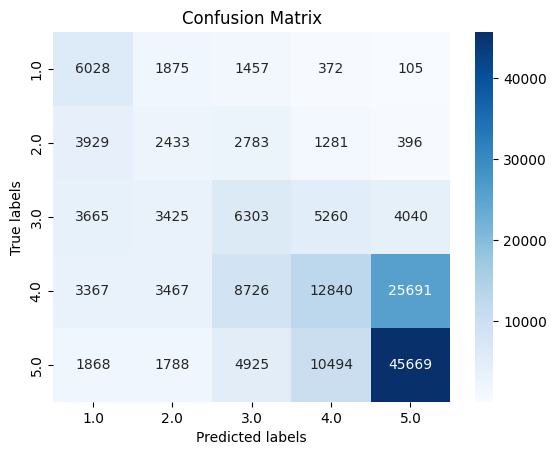

In [ ]:
# Evaluate our model
calc_acc(log_reg_pca, y_pred_pca_log_reg, y_test['overall_rating'])

On a first glance, one would not think this model is very accurate given the 45% accuracy rate. However, because we have 5 different categories, this makes it much harder for the model to predict exactly which number is chosen by the user (compared to binary classification). 

We note that precision first decreases and increases from 1-5, with 5 having the highest precision of 60%, and 2 having the lowest at just 19%. 

There is a similar trend for recall, except now both extremes (including 1) have the highest recall scores. The middle 3 scores (2-4) have significantly lower recall scores.

Looking at F1 scores (which combine recall and precision), in order of highest to lowest: 5,1,4,3,2

The support "scores" simply tell us the number of total occurences of each category. As shown before in our over/undersampling analysis, there is a clear class imbalance where lower scores have much fewer frequencies. 

## Logistic Regression (without PCA)

For the sake of comparison/baseline testing, we ran Logistic Regression without PCA. 

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train a logistic regression model with custom sample weights
over_log_reg = LogisticRegression(random_state=42)
over_log_reg_model = over_log_reg.fit(over_X_train, over_y_train)

under_log_reg = LogisticRegression(random_state=42)
under_log_reg_model = under_log_reg.fit(under_X_train, under_y_train)

# Predict labels based on our models
over_y_pred_log = over_log_reg_model.predict(X_test)
under_y_pred_log = under_log_reg_model.predict(X_test)

              precision    recall  f1-score   support

         1.0       0.29      0.63      0.40      9837
         2.0       0.15      0.18      0.17     10822
         3.0       0.19      0.17      0.18     22693
         4.0       0.37      0.10      0.16     54091
         5.0       0.51      0.73      0.60     64744

    accuracy                           0.40    162187
   macro avg       0.30      0.36      0.30    162187
weighted avg       0.38      0.40      0.35    162187

Accuracy score: 0.39937849519381946


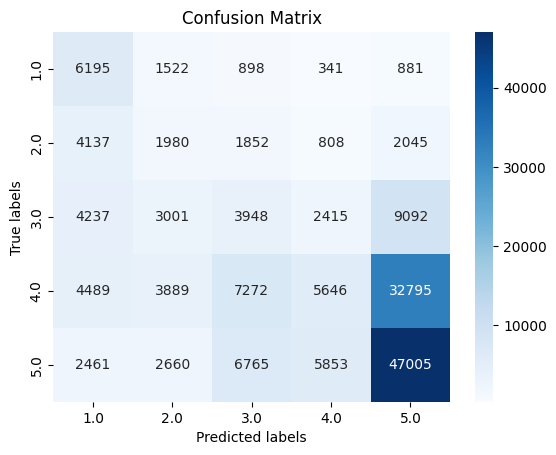

In [ ]:
# Evaluate the oversampled model
calc_acc(over_log_reg_model, over_y_pred_log, y_test['overall_rating'])

              precision    recall  f1-score   support

         1.0       0.29      0.63      0.40      9837
         2.0       0.15      0.19      0.17     10822
         3.0       0.19      0.18      0.19     22693
         4.0       0.38      0.11      0.17     54091
         5.0       0.51      0.72      0.60     64744

    accuracy                           0.40    162187
   macro avg       0.31      0.36      0.30    162187
weighted avg       0.39      0.40      0.36    162187

Accuracy score: 0.3989962204122402


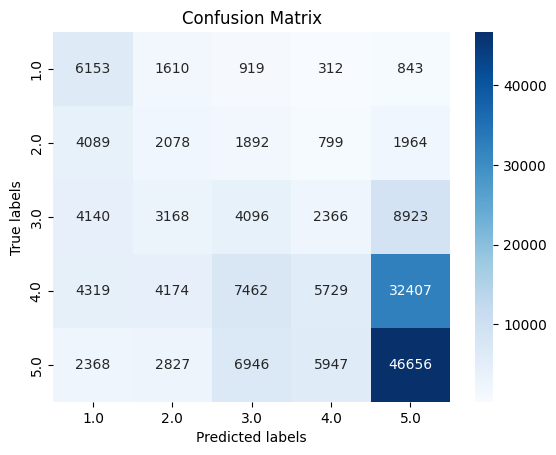

In [ ]:
# Evaluate the undersampled model
calc_acc(under_log_reg_model, under_y_pred_log, y_test['overall_rating'])

There are 2 major observations here: 


1.   Logistic Regression with PCA performed better (45% accuracy compared to 40%).
2.   Using undersampling vs. oversampling did not significantly affect the performance of the model.



## Decision Tree

Our main reason for selecting Decision Tree is to lead into our next model with Random Forest, which is a collection of Decision Trees. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# GridSearchCV to find the best hyperparameters
param_grid = {
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

tree = DecisionTreeClassifier(criterion='gini')
grid_search = GridSearchCV(tree, param_grid=param_grid, cv=3, verbose=1, scoring='f1_weighted')

grid_search.fit(under_X_train, under_y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  0.40706350963836707


In [ ]:
# Assign the best hyperparameters to a variable
best_params = grid_search.best_params_

In [ ]:
# Train a Decision Tree model with custom sample weights
dt_model = DecisionTreeClassifier(**best_params)
dt_model.fit(under_X_train, under_y_train)

# Predict the labels
y_pred_dt = dt_model.predict(X_test)

              precision    recall  f1-score   support

         1.0       0.35      0.60      0.44      9837
         2.0       0.18      0.35      0.24     10822
         3.0       0.23      0.23      0.23     22693
         4.0       0.43      0.24      0.31     54091
         5.0       0.61      0.67      0.64     64744

    accuracy                           0.44    162187
   macro avg       0.36      0.42      0.37    162187
weighted avg       0.45      0.44      0.43    162187

Accuracy score: 0.44017091382169965


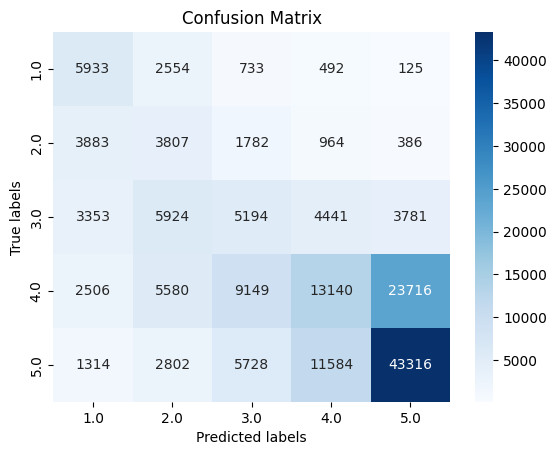

In [ ]:
# Evaluate our model
calc_acc(dt_model, y_pred_dt, y_test['overall_rating'])

We actually see very similar results as the Logistic Regression model with PCA. More analysis on this in the Conclusion section.

## Random Forest

We selected Random Forest because it is a powerful model known for returning high accuracies, especially compared to other models like logistic regression. Additionally, it is able to dampen the effects of overfitting (which is a common issue in decision trees). 

Finally, Random Forests are easy to tune with only a few hyperparameters to optimize. This can save time and computational resources compared to other models with many hyperparameters.

In [ ]:
# Train a Random Forest model with custom sample weights
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(under_X_train, under_y_train)

# Predict the classes
y_pred_rf = rf_model.predict(X_test)

<ipython-input-45-880eb558befc>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(under_X_train, under_y_train)


              precision    recall  f1-score   support

         1.0       0.38      0.62      0.47      9837
         2.0       0.19      0.33      0.24     10822
         3.0       0.24      0.30      0.26     22693
         4.0       0.42      0.29      0.34     54091
         5.0       0.62      0.59      0.61     64744

    accuracy                           0.43    162187
   macro avg       0.37      0.43      0.39    162187
weighted avg       0.46      0.43      0.44    162187

Accuracy score: 0.43496087849211096


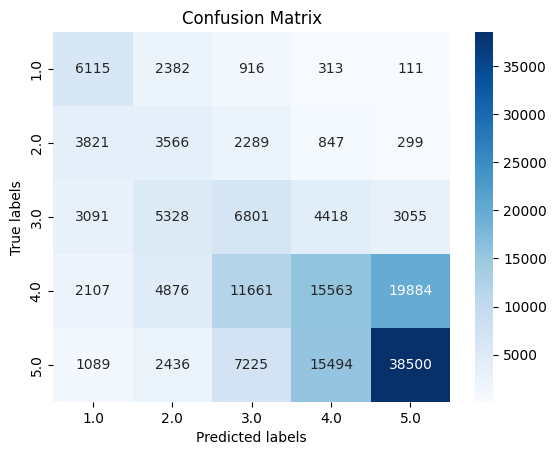

In [ ]:
# Evaluate our models
calc_acc(rf_model, y_pred_rf, y_test['overall_rating'])

Random Forest achieved an accuracy of 43%, again showing many of the same trends in the classification metrics as in previous models (logistic regression, decision tree). 

# Conclusions

## Key Takeaways

Because we want to achieve a high accuracy for low ratings, we will place special emphasis on the recall scores for the low ratings classes (1,2). Recall measures the proportion of true positive predictions among all actual positive cases in the dataset. From both a hotel's users' persepctive, we would like the model to correctly identifying as many low ratings as possible.

This goes back to our class imbalance problem. On a website like TripAdvisor, there tends to be many more favorable ratings compared to unfavorable (we did not explore this, but this could be partially due to the presence of fake online ratings that inflate the ratings of hotels). 

From the perspective of a user who is deciding between which hotel to book, he or she would most likely want to not only look at the average hotel rating (which tends to be quite high across the board), but also the worst ratings. 

From the perspective of hotels, they can benefit from predicting the ratings that certain unsatisfied customers may give them and use that information to help them improve their services. In both cases, the lower ratings are important to take into consideration.

## Comparison of Models

We analyzed several different models and combinations of models, including Logistic Regression with and without PCA, Decision Tree, and Random Forest. 


*   Most of the models actually performed quite similarly to each other, achieving accuracies of 40-45%. 
*   In order of most accurate to least accurate: Logistic Regression with PCA (45.2%), Decision Tree (44.0%), Random Forest (43.5%), Logistic Regression without PCA (40%). 

First, comparing just the accuracy scores, we somewhat surprisingly find out that the Logistic Regression with PCA, Decision Tree, and Random Forest all performed similarly. We expected Random Forest to perform better than Decision Tree and Logistic Regression, but this did not happen. 

One possible explanation for this is that the simpler decision tree and the logistic regression models were able to capture the patterns and relationships in the data with fewer features, and was less prone to overfitting than the random forest model. We can also corroborate this with our initial PCA explained variance analysis: even though we started with 10 features, to achieve 80% explained variance, we only needed 6 features. 

However, as mentioned before, accuracy does not tell the entire story of the results. We will next compare the additional Classication Metric scores across the 3 models with highest accuracies.



In [ ]:
# Creates dataframe comparing the top 3 models' precision, recall, and f1 scores
# first number is unweighted average score, second is weighted
class_metrics_df = pd.DataFrame({'Logistic Regression (with PCA)': ['0.36, 0.45', '0.41, 0.45', '0.37, 0.44'],
                   'Decision Tree': ['0.36, 0.45', '0.42, 0.44', '0.37, 0.43'],
                   'Random Forest': ['0.37, 0.46', '0.43, 0.43', '0.39, 0.44']})
class_metrics_df = class_metrics_df.rename(index={0: 'Precision', 1: 'Recall', 2: 'F1'})
class_metrics_df

,Logistic Regression (with PCA),Decision Tree,Random Forest
Precision,"0.36, 0.45","0.36, 0.45","0.37, 0.46"
Recall,"0.41, 0.45","0.42, 0.44","0.43, 0.43"
F1,"0.37, 0.44","0.37, 0.43","0.39, 0.44"


Note that the first number of each ordered pair of numbers is the unweighted average metric score, and the second number is the weighted average metric score (which is most likely the more useful number to look at since we have class imbalance). 

Overall, these results are extremely close to each other across all categories of score metrics, so it is difficult to say exactly which model is best for predicting the overall rating a user assigns a hotel. 

We can still make a holistic decision taking into account the simplicity of the models. Since Logistic Regression was able to achieve the highest accuracy with relatively fewer resources in general than either Decision Trees or Random Forests, it can be argued that it had the best performance. 

However, we acknowledge that the simplicity of the LR model can also be a downside. Although we did hyperparameter tuning for the Random Forest model, it is still possible that we did not explore the best combination of features and parameters to achieve the highest accuracy that the more complex model could have achieved. This gives Random Forest an advantage in terms of adaptability. For example, though LR performed slightly better on this dataset, there is no guarantee that it will perform better over the other 2 models when given different datasets. 


## Final Words

Overall, our models did not perform too well when trained almost exclusively on the text data since they were only able to correctly identify a review's overall star rating less than 50% of the time. 

We do note that predicting a score from 1 to 5 is more difficult than predicting a binary variable. From the confusion matrices, we see that especially for ratings of 5, 1, and 4, the models do predict the most occurences for 5, 1, and 4. For example, the ratings of 4 and 5 are correctly predicted to have the most samples by the models, but we also note that this could be due to there being many more samples for 4,5 anyway. However, we attempted to address the class imbalance using undersampling. 

We found that undersampling was able to partially improve the precision of the models when predicting scores on the lower end (1,2). Scores of 1 were actually predicted with one of the highest accuracies, only after scores of 5. 

An explanation for this is that extreme reviews tend to have more extreme vocabulary as well, and so the sentiment analyses and doc2vec vectors were able to correctly pick up on this and return the correct result. 

Finally, we can say that there are lots of nuances that go into text analysis that make it difficult to come up with exact trends for predicting ratings. We saw that it was far easier for the model to predict ratings of 1 and 5, but in between, it was much more ambiguous, which is very reasonable.